# Traffic Signs Classification
**Sao Kanneh S3788996**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
import os
from glob import glob
import re
import numpy as np

In [2]:
# variables for training and testing path
datasetPath = 'datasets'
trainPath = os.path.join(datasetPath, 'train')
testPath = os.path.join(datasetPath, 'test')
shapes = ['diamond', 'hex', 'round', 'square', 'triangle']

Here I'm setting up a helper function to build a dataframe from paths. Because the training data is formatted in directories like so: <shape>/<type>

In [3]:
# creates dataframe using the provided path. returns the DataFrame with cos [path, shape, type]
def createTrainDfFromPath():
    print(f'trainPath: {trainPath}')
    train_signs_dict = {
        'path': [],
        'shape': [],
        'type': [],
        'pixels': [],
    }
    columns = ['path', 'shape', 'type', 'pixels']
    # loop through each shape, extract the relevant columns from their images
    for shape in shapes:
        shape_path = os.path.join(trainPath, f'{shape}/')
        print(f'adding images from {shape_path} to df')

        for imgPath in glob(f'{shape_path}/**/*.png', recursive=True):
            # use regex to get a list of directories in this path
            dir_list = re.findall('([a-zA-Z]+)', imgPath)
            im = Image.open(imgPath)
            # the sign-type is in the 3rd index
            sign_type = dir_list[3]
            train_signs_dict['path'].append(imgPath)
            train_signs_dict['shape'].append(shape)
            train_signs_dict['type'].append(sign_type)
            # store the image as a 2D array
            train_signs_dict['pixels'].append(np.asarray(im))
        print(f'{shape} added')

    return pd.DataFrame(train_signs_dict, columns=columns)

## EDA
In this section I will be exploring the images provided in the "train" subdirectory.

Before I can explore them though, I would like an easy way to manage their paths. the best way to do this is to add all image paths to a pandas DataFrame

In [4]:
trafficSignsDf = createTrainDfFromPath()

trainPath: datasets\train
adding images from datasets\train\diamond/ to df
diamond added
adding images from datasets\train\hex/ to df
hex added
adding images from datasets\train\round/ to df
round added
adding images from datasets\train\square/ to df
square added
adding images from datasets\train\triangle/ to df
triangle added


In [5]:
trafficSignsDf.head()

,path,shape,type,pixels
0,datasets\train\diamond\rightofway\00032_00000.png,diamond,rightofway,"[[106, 96, 75, 116, 117, 106, 116, 125, 136, 1..."
1,datasets\train\diamond\rightofway\00032_00001.png,diamond,rightofway,"[[23, 54, 87, 68, 40, 80, 160, 187, 82, 72, 92..."
2,datasets\train\diamond\rightofway\00032_00002.png,diamond,rightofway,"[[59, 61, 60, 62, 61, 59, 59, 57, 61, 59, 57, ..."
3,datasets\train\diamond\rightofway\00037_00000.png,diamond,rightofway,"[[77, 76, 79, 80, 81, 76, 76, 73, 74, 74, 74, ..."
4,datasets\train\diamond\rightofway\00037_00001.png,diamond,rightofway,"[[60, 59, 56, 66, 71, 71, 63, 65, 62, 63, 64, ..."


With the DF built, we can start looking at some of the images. We'll use PIL initially to display the images

In [6]:
pilIm = Image.open(trafficSignsDf['path'].iloc[0])
display(pilIm)

PIL seems to display them in a very small format, matplotlib may work best instead:

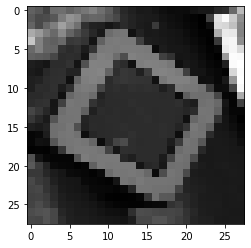

In [7]:
img = mpimg.imread(trafficSignsDf['path'].iloc[0])
imgplot = plt.imshow(img, cmap="gray")
plt.show()

As suspected, matplotlib gives a much better view that is scaled for visibility. Now we explore the images with confidence.

We'll start by looking at the df shape and descriptive stats of our DF

In [8]:
trafficSignsDf.shape

(3699, 4)

In [9]:
trafficSignsDf.describe()

,path,shape,type,pixels
count,3699,3699,3699,3699
unique,3699,5,16,3699
top,datasets\train\diamond\rightofway\00032_00000.png,round,warning,"[[106, 96, 75, 116, 117, 106, 116, 125, 136, 1..."
freq,1,1760,695,1


Observations:
* 3699 total images in our dataset
* Most frequent shape is round, and most frequent sign-type is warning
* 16 unique type values
* 5 unique shape values

The value count of shapes:

In [10]:
trafficSignsDf['shape'].value_counts()

round       1760
triangle     926
square       688
diamond      282
hex           43
Name: shape, dtype: int64

and a plot of the value counts:

<AxesSubplot:>

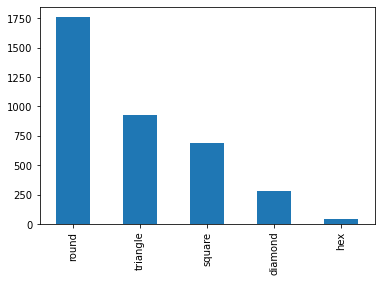

In [11]:
trafficSignsDf['shape'].value_counts().plot(kind='bar')

Observations:
* Most frequent shape in the dataset is the "round" shape with 1760 instances
* Hex is the lest frequent shape in the dataset with 43 instances

The above observations indicate a class imbalance. Because of this, accuracy may not be a good performance metric for the model that predicts shape.

And we repeat the same for sign-type (type in the DF)

In [12]:
trafficSignsDf['type'].value_counts()

warning             695
noentry             375
speed               316
bicycle             285
rightofway          282
parking             276
noparking           242
giveway             231
continue            199
trafficdirective    195
limitedtraffic      125
traveldirection     124
laneend             118
roundabout           98
crossing             95
stop                 43
Name: type, dtype: int64

<AxesSubplot:>

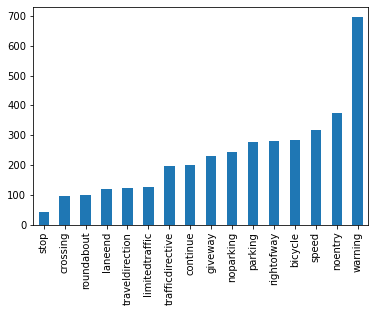

In [13]:
trafficSignsDf['type'].value_counts(ascending=True).plot(kind='bar')

Observations:
* 'noentry' is the most frequent value in the type column with 375 instances
* 'stop' is the least frequent value with 43 instances
* There are 16 unique "sign-type" values

Accuracy may not be the best performance metric due to the imbalanced classes. We may want to choose F2 or Average Precision as our performance metrics. A final decision can be made after some additional exploration

Next, let's see what shapes these sign types belong to

In [14]:
trafficSignsDf[['shape', 'type']]

,shape,type
0,diamond,rightofway
1,diamond,rightofway
2,diamond,rightofway
3,diamond,rightofway
4,diamond,rightofway
...,...,...
3694,triangle,warning
3695,triangle,warning
3696,triangle,warning
3697,triangle,warning


In [15]:
def buildDfListByShape():
    shape_list = []
    for shape in shapes:
        shape_list.append(trafficSignsDf.loc[trafficSignsDf['shape'] == shape])

    return shape_list

shapesDfList = buildDfListByShape()

In [16]:
shapesDfList[1].head()

,path,shape,type,pixels
282,datasets\train\hex\stop\00375_00000.png,hex,stop,"[[100, 136, 100, 74, 75, 88, 103, 86, 110, 77,..."
283,datasets\train\hex\stop\00375_00001.png,hex,stop,"[[88, 47, 247, 199, 43, 76, 96, 77, 86, 53, 71..."
284,datasets\train\hex\stop\00375_00002.png,hex,stop,"[[176, 119, 127, 130, 128, 145, 135, 115, 158,..."
285,datasets\train\hex\stop\00478_00000.png,hex,stop,"[[20, 20, 20, 18, 20, 21, 36, 83, 82, 82, 64, ..."
286,datasets\train\hex\stop\00478_00001.png,hex,stop,"[[53, 48, 41, 72, 58, 77, 60, 57, 60, 65, 66, ..."


In [17]:
# method to access the list using a string
def getDfByShape(shape):
    shape_lookup = {
        'diamond': 0,
        'hex': 1,
        'round': 2,
        'square': 3,
        'triangle': 4,
    }

    shape_ind = shape_lookup[shape]
    return shapesDfList[shape_ind]

Best way to do this is to iterate through the shape-specific dfs created above.

In [18]:
for df in shapesDfList:
    print(f'{df["shape"].iloc[0]} -- associated sign-types value counts:')
    print(f'{df["type"].value_counts()}')
    print()

diamond -- associated sign-types value counts:
rightofway    282
Name: type, dtype: int64

hex -- associated sign-types value counts:
stop    43
Name: type, dtype: int64

round -- associated sign-types value counts:
noentry             375
speed               316
bicycle             285
noparking           242
trafficdirective    195
limitedtraffic      125
traveldirection     124
roundabout           98
Name: type, dtype: int64

square -- associated sign-types value counts:
parking     276
continue    199
laneend     118
crossing     95
Name: type, dtype: int64

triangle -- associated sign-types value counts:
warning    695
giveway    231
Name: type, dtype: int64



Observations:
 * Stop signs are the only types of signs in the shape of a hex
    * Additionally, there are only 43 stop signs in this dataset, which aligns with the number of hexes in the dataset
 * The only types of diamond signs are Right of Way signs.
    * Australia has a variety of diamond sign types, any we build model will not perform well on those in Australia
    * [Australia Diamond Signs](https://www.globalspill.com.au/product-category/road-signs/road-signs-road-signs/warning-road-signs/)
 * Round has the most variety of sign types, with No Entry being the most frequent sign type.
 * The only two types of triangle signs are:
    * warning -- most frequent sign type.
    * giveway

One possible approach may be to train one model on the shape of the signs, and another on the just their types. I can justify this as the sign-types have are easily separated along the shape feature.

Another possible approach is to "flatten" this strucutre, i.e. create boolean columns with the shape and sign type concatenated together - e.g. diamond_rightofway. Though I'm concerned about how this could affect the single model's biases.

We can't make any further observations without seeing the rest of the dataset. Let's build a function to randomly sample each dataset

In [19]:
# seed for reproducible results.
def sampleRandomNImages(n=5, seed=1):
    fig, axes = plt.subplots(nrows=len(shapesDfList), ncols=n, figsize=(14, 14))
    fig.tight_layout(h_pad=5, w_pad=5)
    row_iter = 0
    for df in shapesDfList:
        col_iter = 0
        for index, row in df.sample(n, random_state=seed).iterrows():
            axes[row_iter, col_iter].set_title(f'shape={row["shape"]}, type={row["type"]}', backgroundcolor="white")
            axes[row_iter, col_iter].imshow(row['pixels'], cmap="gray")
            col_iter += 1
        row_iter += 1

In [20]:
def sample_n_images_by_shape_signtype(shape, sign_type = None, n = 5,n_rows = 1 ,seed=1, figsize =(14,14)):
    shape_df = getDfByShape(shape)


    if sign_type is not None:
        sign_df = shape_df.loc[shape_df['type'] == sign_type]

        fig, ax = plt.subplots(n_rows, 5, figsize=figsize)

        row_iter = 0
        col_iter = 0
        for index, row in sign_df.sample(n,random_state=seed).iterrows():

            if n_rows > 1:
                ax[row_iter, col_iter].set_title(f'{shape}-{sign_type}  img')
                ax[row_iter, col_iter].imshow(row['pixels'], cmap="gray")
            else:
                ax[col_iter].set_title(f'{shape}-{sign_type}  img')
                ax[col_iter].imshow(row['pixels'], cmap="gray")

            col_iter += 1

            if col_iter >= 5:
                col_iter = 0
                row_iter += 1

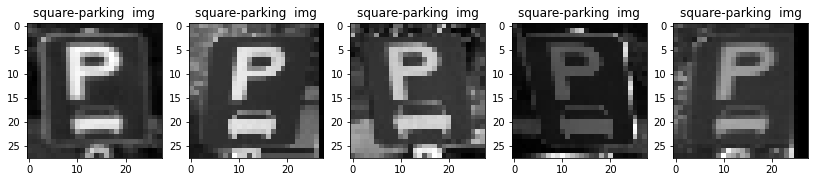

In [21]:
sample_n_images_by_shape_signtype('square', 'parking')

And now let's look at the average diamond image

In [22]:
# util to calculate mean across the sign shape column
def calcMeanShapeImg(df):
    img_mat = None
    for idx, row in df.iterrows():
        row_pix = [row['pixels'].ravel()]
        if img_mat is None:
            img_mat = row_pix
        else:
            img_mat = np.concatenate((img_mat, row_pix))

    mean_img = np.mean(img_mat, axis=0)
    mean_img = mean_img.reshape((28, 28))
    return mean_img


# verify it works as expected
calcMeanShapeImg(shapesDfList[0])

array([[103.95744681, 103.5212766 , 104.24113475, 103.26595745,
        104.53900709, 106.        , 106.52836879, 106.93262411,
        106.19503546, 105.23758865, 104.03546099, 102.42198582,
        102.23049645, 101.79787234, 101.26950355, 101.56028369,
        101.74822695,  98.63829787,  97.9751773 ,  99.62056738,
        101.06382979, 102.77304965, 101.0141844 , 100.13829787,
        100.71276596,  98.58510638,  98.11702128,  99.46099291],
       [103.5177305 , 103.87234043, 104.82269504, 104.31914894,
        103.45744681, 104.46808511, 105.66666667, 106.58156028,
        104.84042553, 103.13829787, 102.37588652, 101.20567376,
         99.69503546,  96.55319149,  96.74822695, 100.68439716,
        100.42198582,  98.5       ,  98.40070922,  99.38297872,
        100.83687943, 101.4787234 , 100.20921986,  99.26950355,
        100.5106383 ,  98.5035461 ,  99.0106383 , 100.69858156],
       [100.44680851, 101.71631206, 103.83333333, 103.91843972,
        103.37234043, 103.4929078 , 10

In [23]:
def calVarShapeImg(df):
    img_mat = None
    for idx, row in df.iterrows():
        row_pix = [row['pixels'].ravel()]
        if img_mat is None:
            img_mat = row_pix
        else:
            img_mat = np.concatenate((img_mat, row_pix))

    var_img = np.var(img_mat, axis=0)
    var_img = var_img.reshape((28, 28))
    return var_img

In [24]:
# util function to calculate average image based on shape, sign-type, or both.
def calcMeanImg():
    mean_dict = {
        'diamond': [],
        'hex': [],
        'round': [],
        'square': [],
        'triangle': []
    }
    for df in shapesDfList:
        mean_dict[df['shape'].iloc[0]] = calcMeanShapeImg(df)

    return mean_dict

def calcVarImg():
    var_dict = {
        'diamond': [],
        'hex': [],
        'round': [],
        'square': [],
        'triangle': []
    }

    for df in shapesDfList:
        var_dict[df['shape'].iloc[0]] = calVarShapeImg(df)

    return var_dict


In [25]:
# save memory and performance, calculate meanImages and variance images once
shapeMeans = calcMeanImg()
shapeVars = calcVarImg()

In [26]:
def displayShapeMeans():
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))
    row_iter = 0
    col_iter = 0
    for sign_shape in shapes:
        axes[row_iter, col_iter].set_title(f'{sign_shape} Mean Image')
        axes[row_iter, col_iter].imshow(shapeMeans[sign_shape], cmap="gray")
        col_iter += 1
        if col_iter > 1:
            row_iter += 1
            col_iter = 0

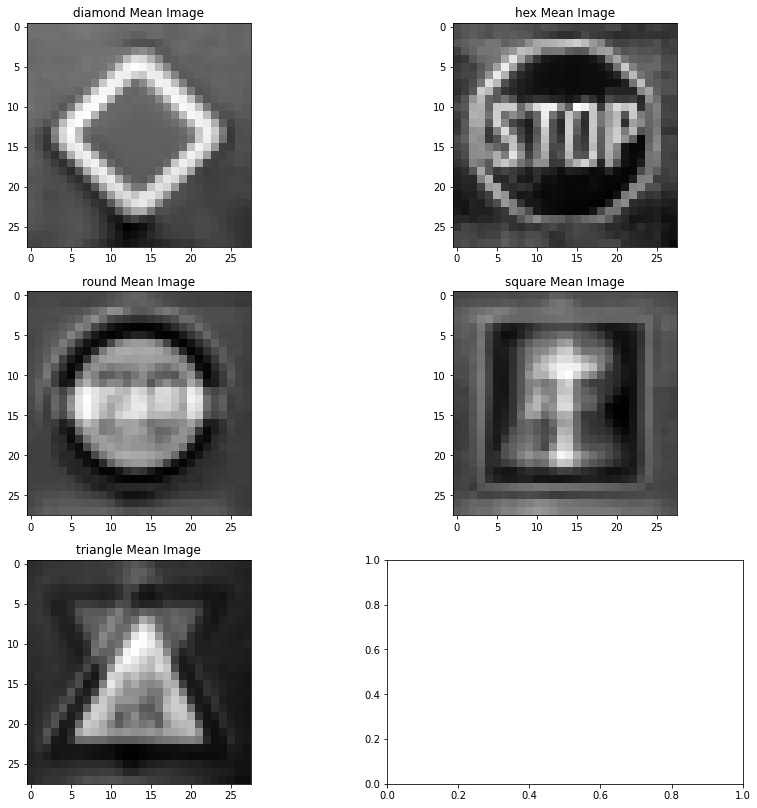

In [27]:
displayShapeMeans()

Observations:
* round and hex have very similar shapes/edges
* there seem to be more triangles pointing upwards than downwards in the dataset
* Diamond & Hex means reaffirm prior observations that they each only have 1 sign-type

Let's see what the contrast is between each mean image

In [28]:
def calcMeanDiff(im1, im2):
    return im1 - im2

In [29]:
t = list(shapeMeans)
t[:0] + t[1:]

['hex', 'round', 'square', 'triangle']

In [30]:
def displayShapeContrast():
    fig, axes = plt.subplots(5, 4, figsize=(14,14))
    fig.tight_layout(h_pad=5, w_pad=5)
    for i in range(0, 5):
        shape_name = shapes[i]
        ex_i_list = shapes[:i] + shapes[i + 1:]
        im1 = shapeMeans[shapes[i]]
        col_iter = 0
        for k in ex_i_list:
            contrast = calcMeanDiff(im1, shapeMeans[k])
            axes[i, col_iter].set_title(f'Diff between {shape_name} & {k}')
            axes[i, col_iter].imshow(contrast, cmap="gray")
            col_iter += 1

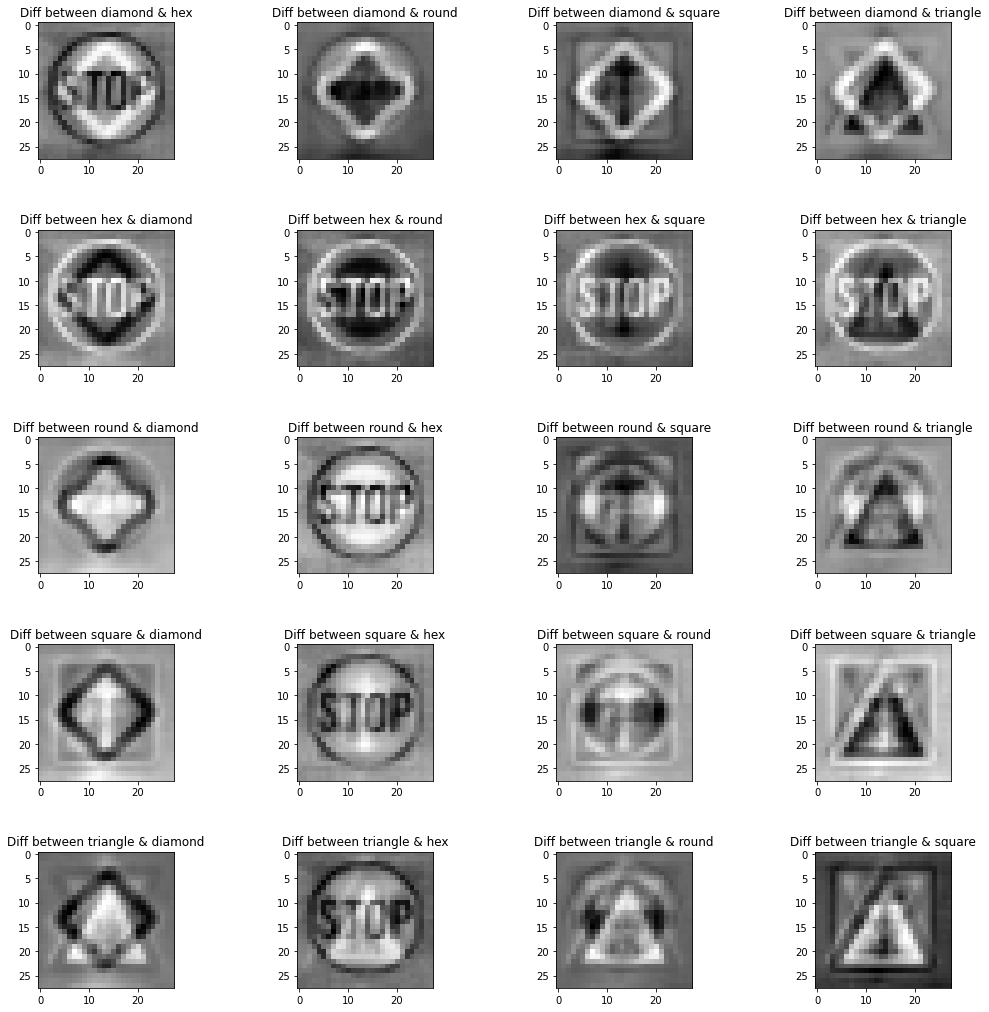

In [31]:
displayShapeContrast()

Observations:
* As above, round and hex have similar edges, but the "stop" in hex presents a prominent difference.

And now let's have a look at their variance and standard deviations:

In [32]:
def displayShapesVar():
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))
    row_iter = 0
    col_iter = 0
    for sign_shape in shapes:
        axes[row_iter, col_iter].set_title(f'{sign_shape} variance Image')
        axes[row_iter, col_iter].imshow(shapeVars[sign_shape], cmap="gray")
        col_iter += 1
        if col_iter > 1:
            row_iter += 1
            col_iter = 0

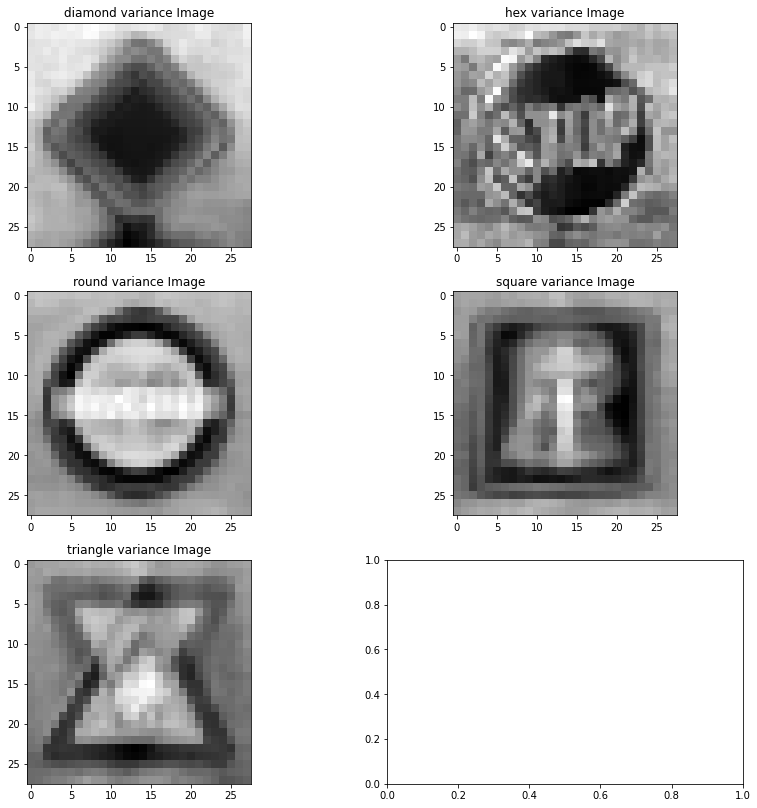

In [33]:
displayShapesVar()

And now we shall explore the sign-types specifically.
First we'll re-create the above utility functions for sign-types

In [34]:
# calculates mean for each sign type in an image. diamond and hex return an array,
# otherwise a dict with sign-types as a key is returned.
def calcSignTypeMean(df, shape):
    mean_im_dict = {

    }
    # diamond and hex shapes only have one type of sign
    if shape == 'diamond' or shape == 'hex':
        mean_im = calcMeanShapeImg(df)
        return mean_im
    else:
        # iterate through each sign-type, add its mean and key to the dictionary
        for sign_type in df['type'].unique():
            type_df = df.loc[df['type'] == sign_type]
            mean_im_dict[sign_type] = calcMeanShapeImg(type_df)

        return mean_im_dict

In [35]:
def buildMeanSignTypesDict():
    mean_im_types_dict = { }
    for i in range(0,5):
        shape_name = shapes[i]
        shape_df = shapesDfList[i]
        mean_im_types_dict[shape_name] = calcSignTypeMean(shape_df, shape_name)

    return mean_im_types_dict

In [36]:
def displayMeanSignTypes(shape, figsize = (25,25)):
    mean_im_types_dict = buildMeanSignTypesDict()

    if isinstance(mean_im_types_dict[shape], dict):
        n_cols = len(list(mean_im_types_dict[shape]))
        fig, ax = plt.subplots(1, n_cols, figsize=figsize)
        fig.tight_layout(h_pad=5, w_pad=5)
        col_iter = 0
        shape_dict = mean_im_types_dict[shape]
        for sign_type in shape_dict:
            ax[col_iter].set_title(f'{shape}-{sign_type} mean')
            ax[col_iter].imshow(shape_dict[sign_type], cmap="gray")
            col_iter += 1

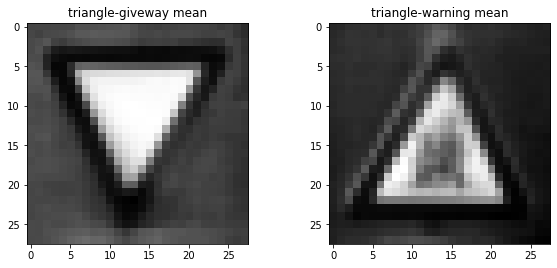

In [37]:
displayMeanSignTypes('triangle', (8,8))

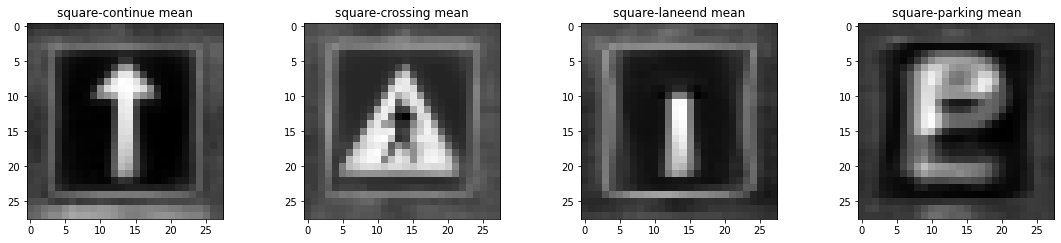

In [38]:
displayMeanSignTypes('square', (15,15))

* There appears to be some noise on the parking sign at the tail end of the "p"
Let's sample images of parking

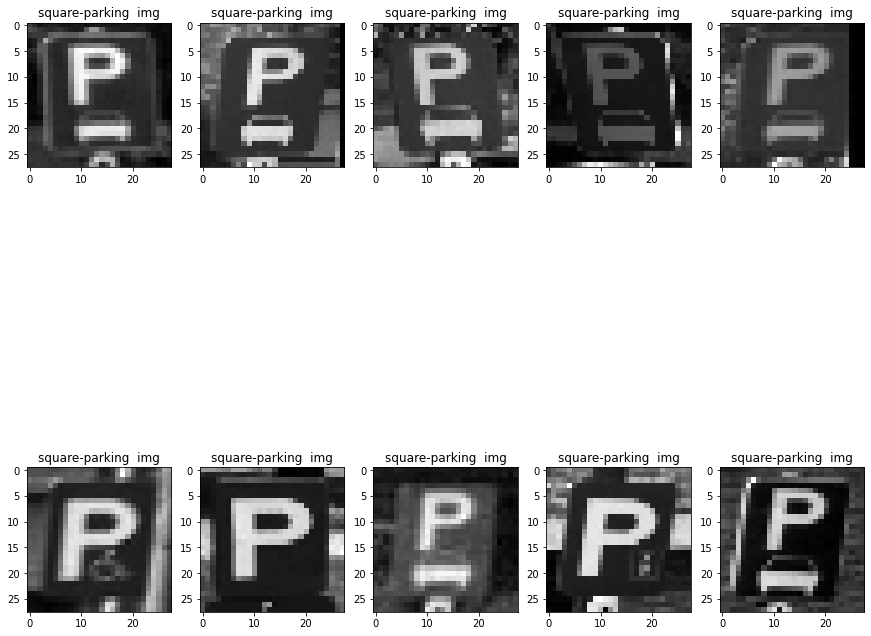

In [39]:
sample_n_images_by_shape_signtype("square", "parking", 10, 2,1,(15,15))

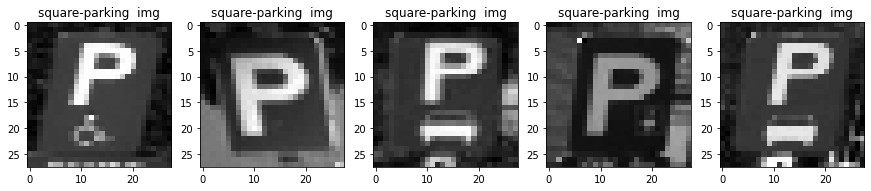

In [40]:
sample_n_images_by_shape_signtype("square", "parking", 5, 1,2,(15,15))

Observations:
* What appeared to be "noise" was just simply the arrows underneath the "P" symbol.
    * Our model is likely to get confused as there are many instances of these double arrows under the parking signs.

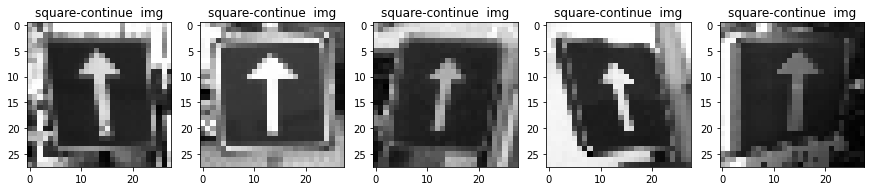

In [41]:
sample_n_images_by_shape_signtype("square", "continue", 5, 1,2,(15,15))

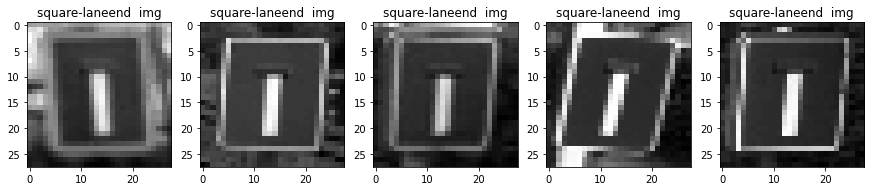

In [42]:
sample_n_images_by_shape_signtype("square", "laneend", 5, 1,2,(15,15))

Now let's take a look at the other shapes

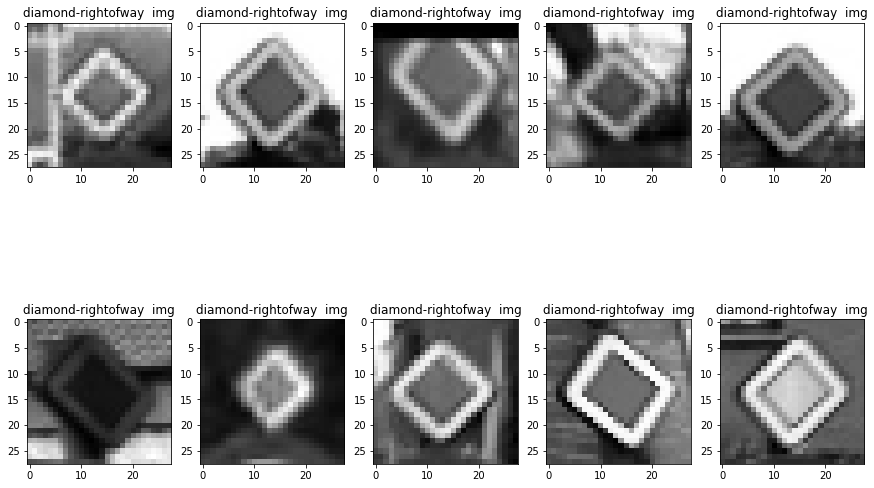

In [43]:
sample_n_images_by_shape_signtype("diamond", "rightofway", 10, 2,1,(15,10))

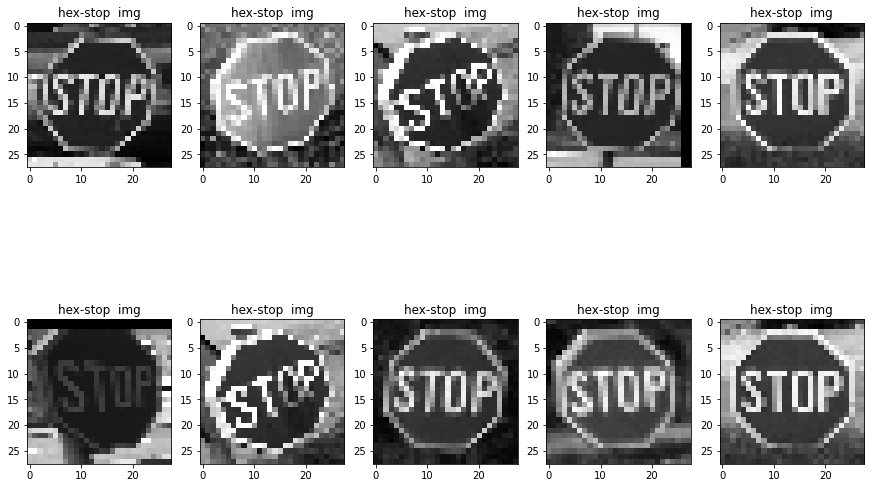

In [44]:
sample_n_images_by_shape_signtype("hex", "stop", 10, 2,1,(15,10))

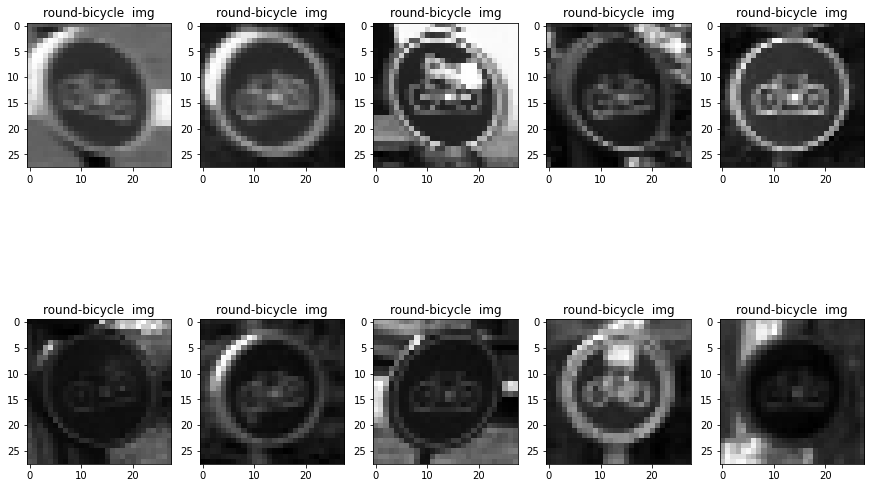

In [45]:
sample_n_images_by_shape_signtype("round", "bicycle", 10, 2,1,(15,10))

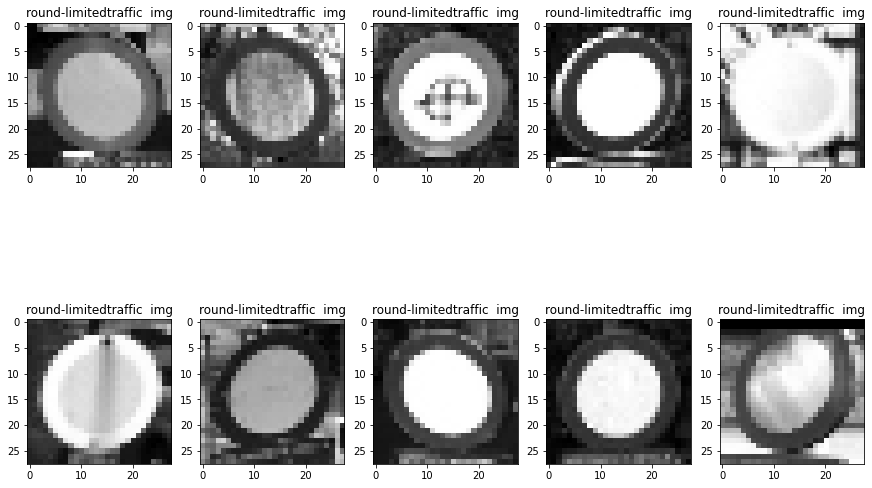

In [46]:
sample_n_images_by_shape_signtype("round", "limitedtraffic", 10, 2,1,(15,10))

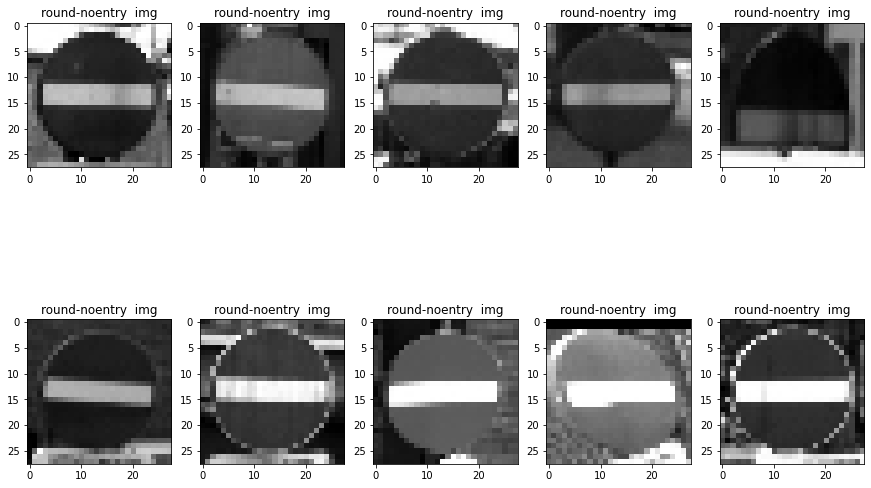

In [47]:
sample_n_images_by_shape_signtype("round", "noentry", 10, 2,1,(15,10))

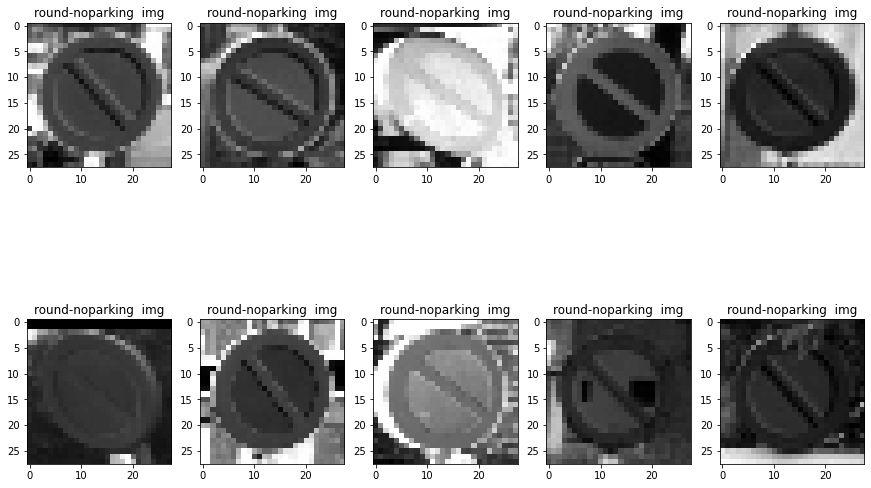

In [48]:
sample_n_images_by_shape_signtype("round", "noparking", 10, 2,1,(15,10))

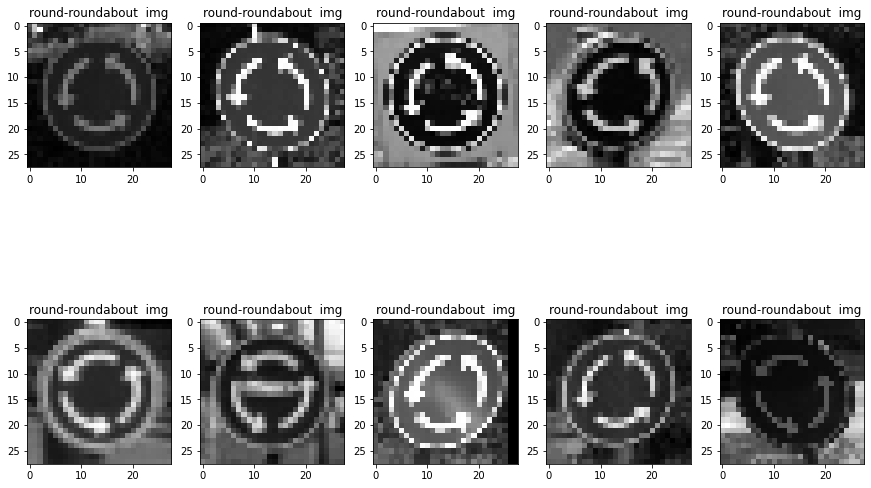

In [49]:
sample_n_images_by_shape_signtype("round", "roundabout", 10, 2,1,(15,10))

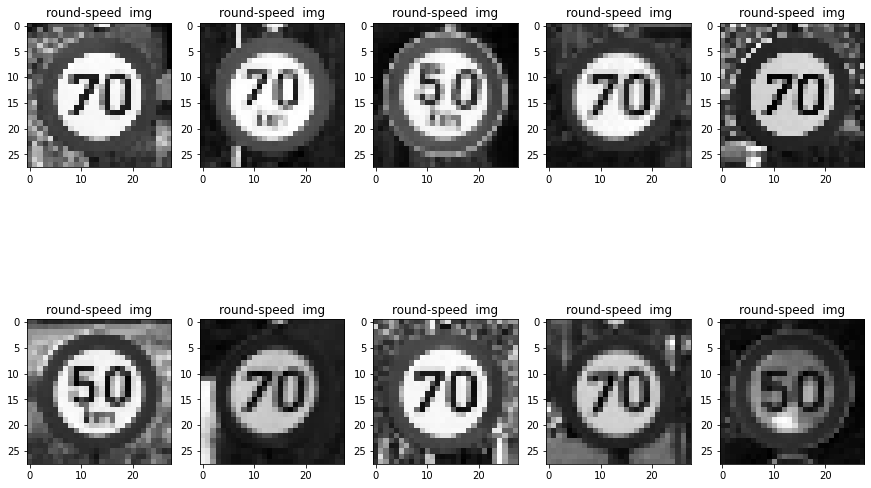

In [50]:
sample_n_images_by_shape_signtype("round", "speed", 10, 2,1,(15,10))

Not an observation, but a possible side project idea: determine the speed written in the sign.

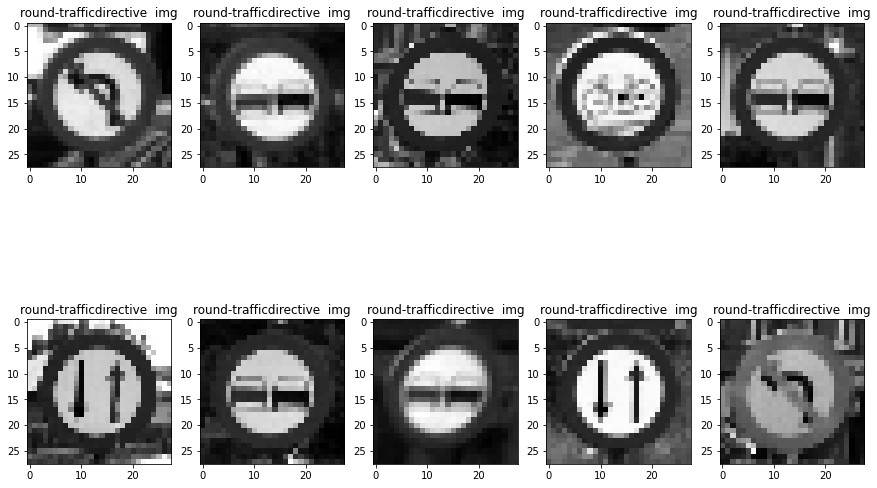

In [51]:
sample_n_images_by_shape_signtype("round", "trafficdirective", 10, 2,1,(15,10))

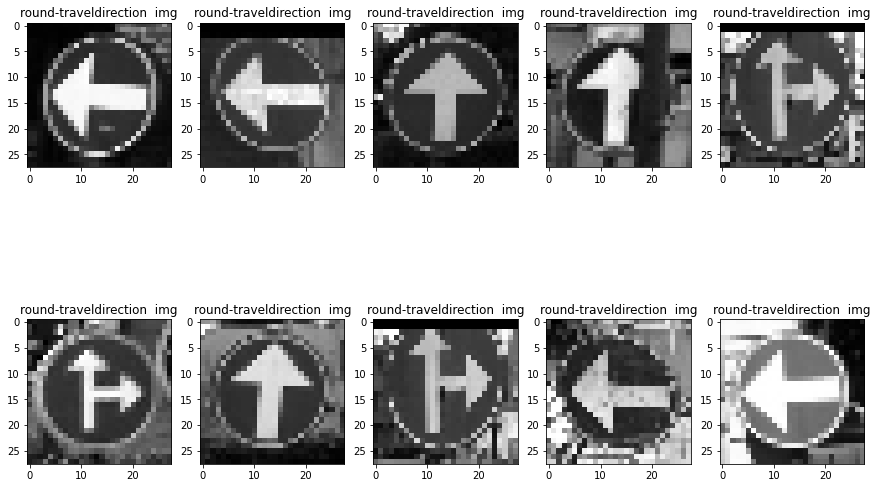

In [52]:
sample_n_images_by_shape_signtype("round", "traveldirection", 10, 2,1,(15,10))

## Traning the Model

Based on our EDA it's clear that our performance metric cannot be accuracy as there is an imbalance of classes too high for accuracy to be good. Possible choices are F1, Precision, or Recall. For the purpose of simplicity I've chosen to use F1 as this is a combined average of precision and recall.

Additionally, I will attempt a few approaches in training the model:
* Train a model using HOG and or PCA
* Train a model without HOG or PCA
* Train two models - one for "shape" and another for "type". (Assuming I don't run out of time)

### HOG/PCA Model

I'll start by looking at the images after they've undergone HOG transformation

In [53]:
from skimage.feature import hog
from skimage import exposure

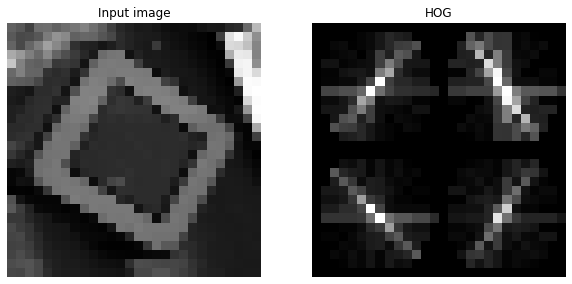

In [54]:
## we'll use the first image in our dataset here -- example from https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
fd, hog_im, = hog(trafficSignsDf['pixels'].iloc[0],orientations=25, pixels_per_cell=(14, 14),
                  cells_per_block=(3, 3), visualize=True)

hog_fig, (hog_ax1,hog_ax2) = plt.subplots(1,2,figsize=(10,5))

hog_ax1.axis('off')
hog_ax1.imshow(trafficSignsDf['pixels'].iloc[0], cmap="gray")
hog_ax1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_im, in_range=(0, 25))

hog_ax2.axis('off')
hog_ax2.imshow(hog_image_rescaled, cmap="gray")
hog_ax2.set_title('HOG')
plt.show()

Observations:
* For the "diamond" shape the hog features extracted are close to the original image
* However there appears to be some additional features that aren't representative of the original image.
* HOG is too complex and may not provide good enough results for the amount of work required to process it.

As we've rejected the notion of building a model with HOG, let's move on training a simple baseline model without it.

But first, the setup

In [55]:
#our X column will be made of only our images
X_images = []

for index, row in trafficSignsDf.iterrows():
    pixels = row['pixels']
    pixels = np.reshape(pixels, 28*28)
    X_images.append(pixels)
X = np.array(X_images)

In [59]:
print(X)
print(len(X))

[[106  96  75 ...  37  38  38]
 [ 23  54  87 ...  96  81  79]
 [ 59  61  60 ...  93  63 125]
 ...
 [ 17  18  19 ...  51  51  55]
 [124 165 165 ...  61  98 138]
 [ 45 177 254 ...  49  62  84]]
3699


In [63]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
y_trafficDf = trafficSignsDf.drop(['path','pixels'],axis=1)
targets = pd.get_dummies(y_trafficDf, columns = ['shape', 'type'])

In [64]:
print(len(targets))

3699


Now that our setup is complete, we can use KFold to train our model and plot a validation curve.

In [58]:
from sklearn.model_selection import KFold


kf = KFold(n_splits=10, shuffle=True, random_state=1)

for train_idx,test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = targets[train_idx], targets[test_idx]



